In [1]:
from torchvision import transforms
from bs4 import BeautifulSoup
from io import StringIO
from PIL import Image
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import torch

In [2]:
url = "https://www.picsearch.com/index.cgi?q=furniture"

In [3]:
import urllib.request

class AppURLopener(urllib.request.FancyURLopener):
    version = "Mozilla/5.0"

opener = AppURLopener()
response = opener.open(url)

C:\Users\andreiliphd\.conda\envs\udacity\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: AppURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  


In [4]:
soup = BeautifulSoup(response)

In [5]:
images_links = soup.find_all('img')
image_transforms = transforms.Compose([transforms.Resize(32),
                                       transforms.CenterCrop(32),
                                       transforms.ToTensor()])

images = torch.zeros(0)
for i in images_links:
    image = opener.open('http://' + i['src'][2:77] + str(224))
    image = Image.open(image)
    image = image_transforms(image)
    image = image.unsqueeze(dim=0)
    images = torch.cat((images, image), 0)
    print(images.shape)
    

torch.Size([1, 3, 32, 32])
torch.Size([2, 3, 32, 32])
torch.Size([3, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([5, 3, 32, 32])
torch.Size([6, 3, 32, 32])
torch.Size([7, 3, 32, 32])
torch.Size([8, 3, 32, 32])
torch.Size([9, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([11, 3, 32, 32])
torch.Size([12, 3, 32, 32])
torch.Size([13, 3, 32, 32])
torch.Size([14, 3, 32, 32])
torch.Size([15, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([17, 3, 32, 32])
torch.Size([18, 3, 32, 32])
torch.Size([19, 3, 32, 32])
torch.Size([20, 3, 32, 32])
torch.Size([21, 3, 32, 32])
torch.Size([22, 3, 32, 32])
torch.Size([23, 3, 32, 32])
torch.Size([24, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([26, 3, 32, 32])
torch.Size([27, 3, 32, 32])
torch.Size([28, 3, 32, 32])
torch.Size([29, 3, 32, 32])


In [6]:
images = torch.cat((images, images), 0)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(conv_dim)
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2,kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(conv_dim*2)
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(conv_dim*4)
        self.conv4 = nn.Conv2d(conv_dim*4, conv_dim*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm4 = nn.BatchNorm2d(conv_dim*8)
        self.conv5 = nn.Conv2d(conv_dim*8, conv_dim*16, kernel_size=4, stride=2, padding=1, bias=False)
        self.fc = nn.Linear(conv_dim*4*4, 1)

        

    def forward(self, x):
        x = F.leaky_relu(self.batch_norm1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.batch_norm2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.batch_norm3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.batch_norm4(self.conv4(x)), 0.2)
        x = self.conv5(x)
        x = x.view(-1, self.conv_dim*4*4)
        x = F.sigmoid(self.fc(x))
        return x


In [8]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim        
        self.t_conv1 = nn.ConvTranspose2d(conv_dim, conv_dim*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(conv_dim*8)
        self.t_conv2 = nn.ConvTranspose2d(conv_dim*8, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(conv_dim*4)
        self.t_conv3 = nn.ConvTranspose2d(conv_dim*4, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(conv_dim*2)
        self.t_conv4 = nn.ConvTranspose2d(conv_dim*2, 3, kernel_size=4, stride=2, padding=1, bias=False)
        self.fc = nn.Linear(z_size, conv_dim*4)
        print('z_size', z_size)


        

    def forward(self, x):
        batch_s = x.shape[0]
        x = self.fc(x)
        x = x.view(batch_s, self.conv_dim, 2, 2)        
        x = F.relu(self.batch_norm1(self.t_conv1(x)))
        x = F.relu(self.batch_norm2(self.t_conv2(x)))
        x = F.relu(self.batch_norm3(self.t_conv3(x)))
        x = self.t_conv4(x)
        x = F.tanh(x)

        
        return x


In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if  hasattr(m.bias, 'data'):
            nn.init.constant_(m.bias.data, 0.0)


In [10]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [11]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)


z_size 100
Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

Generator(
  (t_conv1): ConvTranspose2d(32, 256, kernel_size=(4, 4), stri

In [12]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [13]:
import random
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [14]:
import torch.optim as optim

g_optimizer = optim.Adam(G.parameters(), lr=0.0005)
d_optimizer = optim.Adam(D.parameters(), lr=0.0005)


In [15]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
        
    return x*(feature_range[1] - feature_range[0]) + feature_range[0]

In [16]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=20
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images) in enumerate(images):

            real_images = real_images.unsqueeze(0)
            batch_size = 15
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            d_optimizer.zero_grad()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            z_flex = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z_flex = torch.from_numpy(z_flex).float()
            if train_on_gpu:
                z_flex = z_flex.cuda()


            fake_images = G(z_flex)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # d_loss = 

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z_flex = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z_flex = torch.from_numpy(z_flex).float()
            if train_on_gpu:
                z_flex = z_flex.cuda()
            fake_images = G(z_flex)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake, True) # use real loss to flip labels
            g_loss.backward()
            g_optimizer.step()

            # g_loss = 
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [17]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)


C:\Users\andreiliphd\.conda\envs\udacity\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\andreiliphd\.conda\envs\udacity\lib\site-packages\torch\nn\modules\loss.py:512: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
C:\Users\andreiliphd\.conda\envs\udacity\lib\site-packages\torch\nn\functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 1.4332 | g_loss: 0.8230
Epoch [    1/   50] | d_loss: 0.3773 | g_loss: 4.4913
Epoch [    2/   50] | d_loss: 0.2096 | g_loss: 6.0897
Epoch [    2/   50] | d_loss: 0.3049 | g_loss: 1.9396
Epoch [    3/   50] | d_loss: 0.1396 | g_loss: 3.2280
Epoch [    3/   50] | d_loss: 0.0711 | g_loss: 3.7657
Epoch [    4/   50] | d_loss: 0.0388 | g_loss: 4.0734
Epoch [    4/   50] | d_loss: 0.0951 | g_loss: 4.0687
Epoch [    5/   50] | d_loss: 0.2321 | g_loss: 2.8947
Epoch [    5/   50] | d_loss: 0.3423 | g_loss: 2.7946
Epoch [    6/   50] | d_loss: 0.2827 | g_loss: 2.2282
Epoch [    6/   50] | d_loss: 0.1084 | g_loss: 3.8487
Epoch [    7/   50] | d_loss: 0.8178 | g_loss: 2.7588
Epoch [    7/   50] | d_loss: 0.5923 | g_loss: 3.3276
Epoch [    8/   50] | d_loss: 0.7045 | g_loss: 3.2204
Epoch [    8/   50] | d_loss: 0.0876 | g_loss: 4.1813
Epoch [    9/   50] | d_loss: 0.6508 | g_loss: 3.3024
Epoch [    9/   50] | d_loss: 2.6886 | g_loss: 3.6317
Epoch [   10/   50] | d_loss

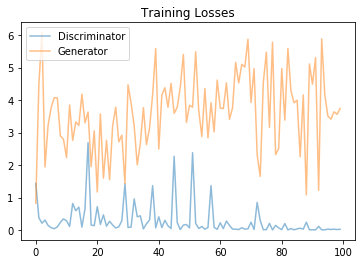

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()


In [19]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))


In [20]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)


# Results

GAN generated a chair from set of furniture pictures from Picsearch. Pictures were dynamically fetched from the website. It's a MVP. Additional work is required.

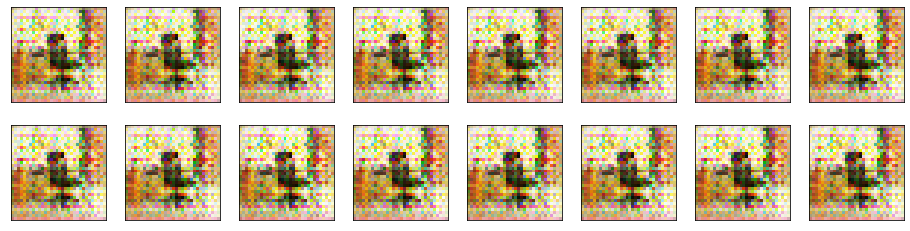

In [21]:
_ = view_samples(-1, samples)
